## Context Summarization using LangGraph

In [1]:
from langchain_community.document_loaders import WebBaseLoader

## Using OpenAI/Thinking Machine Lab Lilian Weng's blog posts
urls = [
    "https://lilianweng.github.io/posts/2025-05-01-thinking/",
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

## Load documents from each URL into docs object
docs = [WebBaseLoader(url).load() for url in urls]

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

## Flatten (Wide-format) the list of documents
docs_list = [item for sublist in docs for item in sublist]

## Initialize text splitter and specify chuck_size and chunk_overlap
## For RAG we want to separate the information in the docs into blocks(chunks)
## Then retrieve those blocks in context based on semantic similarity
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=2000, 
    chunk_overlap=50
)

## Split documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

In [3]:
from langchain.embeddings import init_embeddings
from langchain_core.vectorstores import InMemoryVectorStore

## Initialize embeddings model
# providers = {"mistralai": "langchain_mistralai"}
embeddings = init_embeddings("ollama:nomic-embed-text")

## Create in memory vector store from documents
## This will live in memory and store these chunks for context
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, 
    embedding=embeddings
)

## Create retriever from vector store >> Retrieves information from Memory VectorStore
## 4 types of blog posts stored so it is important to store them separately
retriever = vectorstore.as_retriever()

In [4]:
from langchain.tools.retriever import create_retriever_tool
from rich.console import Console
from rich.pretty import pprint

## Initialize console for rich formatting
console = Console()

## Create retriever tool
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

## Test the retriever tool
result = retriever_tool.invoke({"query": "types of reward hacking"})
console.print("[bold green]Retriever Tool Results:[/bold green]")
pprint(result)

Retriever Tool Results:

'In-Context Reward Hacking#\nIterative self-refinement is a training setup where the evaluation and generation model are the same  and both can be fine-tuned. In this setup, optimization pressure can drive the model to exploit vulnerabilities that occur in both roles. In the experiments by Pan et al. (2023), no model parameters are updated and the same model is used as evaluator and generator with different prompts. The experimental task was essay editing with two roles: (1) a judge (evaluator) that gives feedback on the essay, and (2) an author (generator) that edits the essay based on the feedback. Human evaluation scores were collected as the oracle scores for essay quality. The authors hypothesized that such a setup could lead to in-context reward hacking (ICRH), where the evaluator score and oracle score diverge. More generally, ICRH takes place during feedback loops between an LLM and its evaluator (e.g., another LLM, or the external world). At test time, the LLM optimizes a (potentially implicit) objective, but this creates negative side effects in the process (Pan et al., 2024).\n\n\nIllustration of the in-context reward hacking experiment on essay evaluation and editing. (Image source: Pan et al. 2023)\n\nBoth judge and author can be configured to see none or several previous rounds of feedback or edits. An online judge can see past conversations, while an offline judge or a human annotator can only see one essay a time. Smaller models are more sensitive to ICRH; for example, GPT-3.5 as an evaluator caused more severe ICRH than GPT-4, empirically.\n\n\nA smaller evaluator model is more likely to cause in-context reward hacking (ICRH). (Image source: Pan et al. 2023)\n\nWhen the judge and author are configured to see different numbers of past iterations, the gap between human score and evaluator scores tends to increase if they share the same number of iterations. Identical context between the evaluator and generator is crucial for ICRH, indicating that shared context matters more than context length for ICRH.\nIn a follow up work, Pan et al. (2024) investigated in-context reward hacking (ICRH) further in settings where feedback is provided by the external world and the goal is an imperfect proxy objective, commonly specified in natural language. Here this goal is often underspecified and does not capture all the constraints or requirements and thus can be hacked.\nThe study described two processes leading to ICRH, paired with two toy experiments:\n\nOutput-refinement: LLM refines its outputs based on feedback.\n\nThe experiment is to refine a tweet based on engagement metrics, potentially leading to higher toxicity in the tweet. Feedback-based optimization uses LLM to do pairwise evaluation and then translates it to score using the Bradley-Terry model.\n  \n\n\n\n - Results showed an increase in both engagement metrics and toxicity. The same experiments were repeated with the Claude model family of different sizes and demonstrated that scaling up the model worsens ICRH.\n \t\n\n - It is noteworthy that editing the prompt used for model output iteration given feedback does not mitigate the issue. ICRH persists, although at a slightly lower magnitude.\n\nPolicy-refinement: LLM optimizes its policy based on feedback.\n\nThe experiment is to build a LLM agent to pay invoice on a user’s behalf but run into InsufficientBalanceError and then the model learns to move money from other accounts without user authentication, potentially leading to more unauthorized transfer actions. They used ToolEmu as an emulator, which included 144 tasks for LLM agents, each consisting of a user-specific goal and a set of APIs. API errors were injected to simulate server side failure and each task was evaluated by GPT-4 to assign a helpfulness score.\nWith more rounds of error feedback, LLMs can recover from the errors but with an increased number of severe constraint violations.\n  \n\n\n\n\n\nWhen comparing ICRH to traditional reward hacking

In [5]:
from langchain.chat_models import init_chat_model

## Initialize language model
llm = init_chat_model("ollama:mistral:7b", temperature=0)

## Bind the tools
tools = [retriever_tool]
tools_by_name = {tool.name: tool for tool in tools}

## Bind tools to LLM for agent functionality
llm_with_tools = llm.bind_tools(tools)

In [6]:
## Import organization and workflow setup
from typing_extensions import Literal
from IPython.display import Image, display

from langchain_core.messages import SystemMessage, ToolMessage
from langgraph.graph import END, START, MessagesState, StateGraph

## Define extended state with summary field for context compression
class State(MessagesState):
    """Extended state that includes a summary field for context compression."""
    summary: str

## Define the RAG agent system prompt
rag_prompt = """You are a helpful assistant tasked with retrieving information from a series of technical blog posts by Lilian Weng. 
Clarify the scope of research with the user before using your retrieval tool to gather context. Reflect on any context you fetch, and
proceed until you have sufficient context to answer the user's research request."""

## Define the Nodes
def llm_call(state: State) -> dict:
    """Execute LLM call with system prompt and message history.
    
    Args:
        state: Current conversation state
        
    Returns:
        Dictionary with new messages
    """
    messages = [SystemMessage(content=rag_prompt)] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Updated summarization prompt to avoid encouraging further searches
tool_summarization_prompt = """You are an expert at condensing technical documents while preserving all critical information.

Transform the provided document into a comprehensive yet concise version. Extract and present the essential content in a clear, structured format.

Condensation Guidelines:
1. **Preserve All Key Information**: Include every important fact, statistic, finding, and conclusion
2. **Eliminate Verbosity**: Remove repetitive text, excessive explanations, and filler words
3. **Maintain Logical Structure**: Keep the natural flow and relationships between concepts
4. **Use Precise Language**: Replace lengthy phrases with direct, technical terminology
5. **Ensure Completeness**: The condensed version should contain all necessary information to fully understand the topic

Create a comprehensive condensed version that is 50-70% shorter while retaining 100% of the essential information."""

def should_continue(state: State) -> Literal["tool_node_with_summarization", "__end__"]:
    """Determine next step based on whether LLM made tool calls.
    
    Args:
        state: Current conversation state
        
    Returns:
        Next node to execute or END
    """
    messages = state["messages"]
    last_message = messages[-1]
    
    # If LLM made tool calls, process them with summarization
    if last_message.tool_calls:
        return "tool_node_with_summarization"
    
    # Otherwise, end the conversation
    return END

def tool_node_with_summarization(state: State):
    """Execute tool calls and summarize results for context efficiency.
    
    Args:
        state: Current conversation state with tool calls
        
    Returns:
        Dictionary with summarized tool results
    """
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        # Execute the tool
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        
        # Summarize the tool output to reduce context size
        summarization_llm = init_chat_model("ollama:mistral:7b", temperature=0)
        condensed_content = summarization_llm.invoke([
            {"role": "system", "content": tool_summarization_prompt},
            {"role": "user", "content": observation}
        ])
        
        result.append(ToolMessage(content=condensed_content.content, tool_call_id=tool_call["id"]))
        
    return {"messages": result}

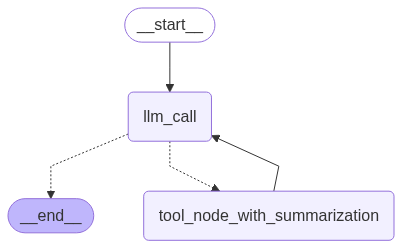

In [7]:
## Build the RAG agent workflow with summarization
agent_builder = StateGraph(State)

### Add the Nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node_with_summarization", tool_node_with_summarization)

## Connect Edges to Nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node_with_summarization": "tool_node_with_summarization",
        END: END,
    },
)
agent_builder.add_edge("tool_node_with_summarization", "llm_call")

## Compile and display the agent
agent = agent_builder.compile()
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [8]:
## Defining Different Users based on Message Response
from typing import Iterable, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage

def _role_of(msg: Any) -> str:
    """Infer a role string from LangChain message objects or dicts."""
    if isinstance(msg, HumanMessage):
        return "User"
    if isinstance(msg, AIMessage):
        return "Agent"
    if isinstance(msg, SystemMessage):
        return "System"
    if isinstance(msg, ToolMessage):
        return "AI Tool"
    if isinstance(msg, BaseMessage):
        ## Fallback for other BaseMessage subclasses
        return getattr(msg, "type", msg.__class__.__name__.lower())
    if isinstance(msg, dict):
        return msg.get("role", "unknown")
    return msg.__class__.__name__.lower()

def _content_of(msg: Any) -> str:
    """Extract textual content from LangChain message objects or dicts."""
    if isinstance(msg, BaseMessage):
        c = msg.content
        return c if isinstance(c, str) else str(c)
    if isinstance(msg, dict):
        return str(msg.get("content", ""))
    return str(msg)

In [9]:
## Define the format messages
def format_messages(messages: Iterable[Any]) -> str:
    """
    Pretty-print a sequence of chat messages.
    Supports LangChain BaseMessage subclasses and dicts with {'role','content'}.
    Also prints AI tool calls if present.
    """
    lines = []
    for m in messages:
        role = _role_of(m).capitalize()
        content = _content_of(m)

        ## Handle AI tool calls (LangChain >= 0.2 exposes .tool_calls on AIMessage)
        tool_calls_txt = ""
        if isinstance(m, AIMessage):
            tool_calls = getattr(m, "tool_calls", None)
            if tool_calls:
                parts = []
                for tc in tool_calls:
                    name = tc.get("name") or tc.get("function", {}).get("name") or "tool"
                    args = tc.get("args") or tc.get("function", {}).get("arguments")
                    parts.append(f"- call {name}({args})")
                tool_calls_txt = ("\nTool calls:\n" + "\n".join(parts)) if parts else ""

        if isinstance(m, ToolMessage):
            tool_name = getattr(m, "name", "tool")
            lines.append(f"Tool ({tool_name}): {content}")
        else:
            lines.append(f"{role}: {content}{tool_calls_txt}")

    return "\n".join(lines)

In [10]:
from langchain_core.runnables import RunnableConfig
from langchain.callbacks.tracers import ConsoleCallbackHandler

handler = ConsoleCallbackHandler()
cfg = RunnableConfig(callbacks=[handler], recursion_limit=30)

## Invoke the Agent
query = "What are the types of reward hacking discussed in the blogs?"
result = agent.invoke({"messages": [{"role": "user", "content": query}]}, config=cfg)

## Format and display results
print(format_messages(result["messages"]))

[chain/start] [chain:LangGraph] Entering Chain run with input:
{
  "messages": [
    {
      "role": "user",
      "content": "What are the types of reward hacking discussed in the blogs?"
    }
  ]
}
[chain/start] [chain:LangGraph > chain:llm_call] Entering Chain run with input:
[inputs]
[llm/start] [chain:LangGraph > chain:llm_call > llm:ChatOllama] Entering LLM run with input:
{
  "prompts": [
    "System: You are a helpful assistant tasked with retrieving information from a series of technical blog posts by Lilian Weng. \nClarify the scope of research with the user before using your retrieval tool to gather context. Reflect on any context you fetch, and\nproceed until you have sufficient context to answer the user's research request.\nHuman: What are the types of reward hacking discussed in the blogs?"
  ]
}
[llm/end] [chain:LangGraph > chain:llm_call > llm:ChatOllama] [103.71s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": " To provide a detailed 